In [1]:
!pip install easyocr

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best Template: doc.png, Matching Score: 0.9574053287506104
Match Found
Type of document: Medical report
['apollo hospitals', 'apollo', 'hospitals', 't 0 u c h |n g', 'liv e $', "patient' s name", 'clark-baldwin', 'date of birth', '18.07.04', 'ward', '05', 'hospital', 'apollo', 'consultant', 'rajeshwari', 'dear doctor', 'the above patient; who is currently an in-patient under your care, is due to be admitted to one', 'of our care homes. in order that we can safely look after him/her; we need you to send us', 'information about his/her medical history', '', 'please can you send a discharge summary; including the following information', '', "doctor' s signature_", 'dale', '', 'hospital stamp', 'name of doctor', 'hospital', 'tel', '', 'email', '']
REAL DOCUMENT


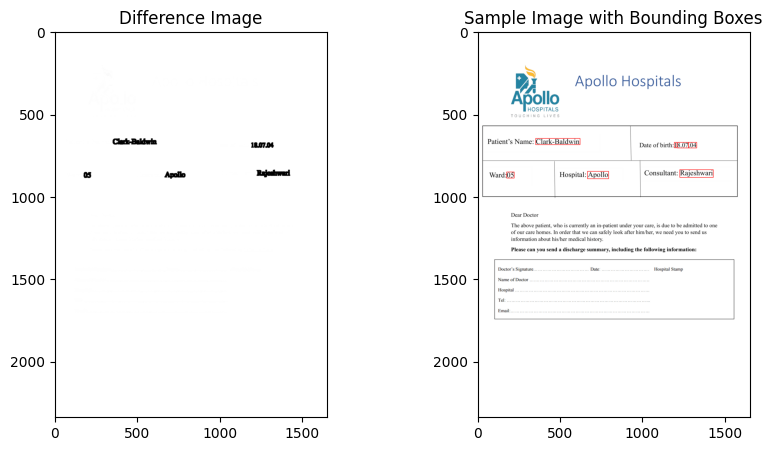

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/MPMC")
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import csv
from skimage.metrics import structural_similarity as ssim
import imutils

template_paths = ['bill_m.png', 'doc.png', 'YASHODA-HOSPITALS.png']
sample_path = 'doc1.png'
dataset_path = 'dataset_y.csv'


def recognize_text(img_path):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(img_path)

    flattened_lines = [item.strip().lower() for line in result for item in (line[1].split(':', 1) if len(line) == 3 else [line[1]])]

    return flattened_lines


def check_attributes_in_dataset(attributes, dataset_path):
    # Checking if all attributes are in the dataset
    with open(dataset_path, 'r') as dataset_file:
        csv_reader = csv.reader(dataset_file)
        for row in csv_reader:
            # Removing spaces and converting them to lowercase
            row_attributes = [attr.strip().lower() for attr in row]
            if all(attr in attributes for attr in row_attributes):
                return True
    return False


def template_matching(sample_path, template_paths, dataset_path):
    sample_img = cv2.imread(sample_path)

    if sample_img is None:
        print(f"Error loading sample image: {sample_path}")
        return

    sample_img_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

    max_matching_score = 0
    best_template_path = None

    for template_path in template_paths:
        # Load the template image
        template = cv2.imread(template_path)

        if template is None:
            print(f"Error loading template: {template_path}")
            continue

        # Resizing template to match sample image dimensions
        template = cv2.resize(template, (sample_img.shape[1], sample_img.shape[0]))

        # Converting the template to grayscale
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

        # Template matching
        res = cv2.matchTemplate(sample_img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
        matching_score = np.max(res)

        # Updating the template with the highest matching score
        if matching_score > max_matching_score:
            max_matching_score = matching_score
            best_template_path = template_path
    if best_template_path=='bill_m.png':
         dataset_path='bill_dataset.csv'
    elif best_template_path=='YASHODA-HOSPITALS.png':
         dataset_path='YASHODA_dataset.csv'
    elif best_template_path=='doc.png':
         dataset_path='APOLLO_dataset.csv'
    if best_template_path is not None and max_matching_score > 0.2:
        print(f"Best Template: {best_template_path}, Matching Score: {max_matching_score}")

        if max_matching_score > 0.6:
            print("Match Found")
            if best_template_path == 'YASHODA-HOSPITALS.png' or 'doc.png':
               print("Type of document: Medical report")

            else:
                 if best_template_path =='bill.png' or 'bill_m.png':
                    print("Type of document: BILL")

            template = cv2.imread(best_template_path)
            template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
            # Calculating the structural similarity index
            (score, diff) = ssim(template_gray, sample_img_gray, full=True)
            diff = (diff * 255).astype("uint8")

            # Threshold the difference image
            thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

            # Finding contours in the thresholded image
            contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = imutils.grab_contours(contours)

            # Looping over the contours
            for contour in contours:
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(sample_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

                # Display the difference image and the sample image with bounding boxes
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(diff, cmap='gray')
            plt.title('Difference Image')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
            plt.title('Sample Image with Bounding Boxes')

            if max_matching_score > 0.8:
                # Extracting detected text from OCR result
                result = recognize_text(sample_path)
                detected_text = result
                print(detected_text)

                # Loading dataset
                with open(dataset_path, 'r') as dataset_file:
                    csv_reader = csv.reader(dataset_file)
                    dataset = list(csv_reader)

                    # Checking for discrepancies in patient details
                    discrepancies_found = False
                    for row in dataset:
                        row_attributes = [attr.lower() for attr in row]
                        if all(attr in detected_text for attr in row_attributes):
                            discrepancies_found = True
                            break

                    # If a match is found
                    if discrepancies_found:
                        print("REAL DOCUMENT")
                    else:
                    # If no match is found
                        print("Error in data: Potential Fraud")
            # Continue with the existing code for potential fraud checks
            else:
                print("Potential Fraud")
    else:
        print("Fraud")


# Example usage:
template_matching(sample_path, template_paths,dataset_path)